See also https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

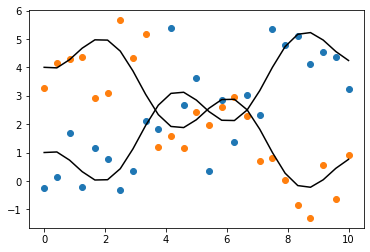

In [41]:
n = 25
x = np.linspace(0,10,num=n)
mu = x*.5+np.cos(1.5*x)
y1 = mu+np.random.randn(n)
y2 = 5-mu+np.random.randn(n)
plt.plot(x,mu,'black',x,5-mu,'black')
plt.scatter(x,y1)
plt.scatter(x,y2)
x.shape = (n,1)

In [42]:
def build_gp(amplitude, length_scale):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    return tfd.GaussianProcess(kernel=kernel, index_points=x, observation_noise_variance=0.0)

def build_mv_obs_model(gp, w1, w2, sigma):
    y1 = tfd.Normal(loc = w1*gp, scale=sigma)
    y2 = w2*gp+tfd.Normal(loc=0., scale=sigma)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'w1': tfd.Normal(loc=0., scale=np.float64(1.)),
    'w2': tfd.Normal(loc=0., scale=np.float64(1.)),
    'sy': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'gp': build_gp,
    'y1': w1*gp
})

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]


In [43]:
s = gp_joint_model.sample()
lp = gp_joint_model.log_prob(s)

print("sampled {}".format(s))
print("log_prob of sample: {}".format(lp))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=2.250661252010473>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=1.5382773927326185>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=4.48961517798302>, 'observations': <tf.Tensor: shape=(25,), dtype=float64, numpy=
array([-6.01963924, -3.08045902, -6.19668794, -3.49094858,  0.68872315,
       -2.8600398 , -2.82839628, -0.81223964, -0.18832807,  3.39734366,
        6.32361848,  6.24377939,  4.23761431,  3.54669762,  0.21398779,
       -2.53875405, -3.05297152, -5.87221548, -5.82712552, -8.91059986,
       -6.52727102, -6.77828652, -1.66650816,  0.29278535,  2.02187897])>}
log_prob of sample: -64.59152563162189


In [44]:
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': y1
  })


In [45]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 2.14930691768362
length_scale: 1.293523689117645
observation_noise_variance: 0.9449491487657832


In [46]:
predictive_index_points_ = np.linspace(-1, 11, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x,
    observations=y1,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)
num_samples = 50
samples = gprm.sample(num_samples)

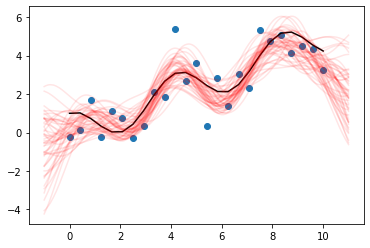

In [47]:
plt.plot(x,mu,c='black')
plt.scatter(x,y1)
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1,
             label='Posterior Sample' if i == 0 else None)

In [38]:
y1.shape

(50,)